In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub

/Users/torokpeter/Documents/tuw/first/machine_learning/machinelearning-tuw/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Although we did some exploratory data analysis in EX0, now that we have to build a model on it, we should definietly go deeper.

In [3]:
path = kagglehub.dataset_download("valakhorasani/gym-members-exercise-dataset")
print(path)
df = pd.read_csv(f'{path}/gym_members_exercise_tracking.csv')
df.head()

/Users/torokpeter/.cache/kagglehub/datasets/valakhorasani/gym-members-exercise-dataset/versions/1


,Age,Gender,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Workout_Type,Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI
0,56,Male,88.3,1.71,180,157,60,1.69,1313.0,Yoga,12.6,3.5,4,3,30.20
1,46,Female,74.9,1.53,179,151,66,1.30,883.0,HIIT,33.9,2.1,4,2,32.00
2,32,Female,68.1,1.66,167,122,54,1.11,677.0,Cardio,33.4,2.3,4,2,24.71
3,25,Male,53.2,1.70,190,164,56,0.59,532.0,Strength,28.8,2.1,3,1,18.41
4,38,Male,46.1,1.79,188,158,68,0.64,556.0,Strength,29.2,2.8,3,1,14.39


Out of the two self chosen dataset, this one has no missing data, and requires minimal preprocessing before we could do modeling. However just to make sure, and show our work, we'll go over those as well.

First let's check for any missing data, look at the shape, check if all data types are correct, check for duplicates and look at the overall summary

In [4]:
print(f'missing values in dataset: \n{df.isnull().sum()} \n')
print(f'duplicates: {df.duplicated().sum()}')
print(f'shape: {df.shape} \n')
print(f'data types in df: \n{df.dtypes}')

missing values in dataset: 
Age                              0
Gender                           0
Weight (kg)                      0
Height (m)                       0
Max_BPM                          0
Avg_BPM                          0
Resting_BPM                      0
Session_Duration (hours)         0
Calories_Burned                  0
Workout_Type                     0
Fat_Percentage                   0
Water_Intake (liters)            0
Workout_Frequency (days/week)    0
Experience_Level                 0
BMI                              0
dtype: int64 

duplicates: 0
shape: (973, 15) 

data types in df: 
Age                                int64
Gender                            object
Weight (kg)                      float64
Height (m)                       float64
Max_BPM                            int64
Avg_BPM                            int64
Resting_BPM                        int64
Session_Duration (hours)         float64
Calories_Burned                  float64
Workout_Typ

In [5]:
print(f'summary: \n {df.describe()}')

summary: 
               Age  Weight (kg)  Height (m)     Max_BPM     Avg_BPM  \
count  973.000000   973.000000   973.00000  973.000000  973.000000   
mean    38.683453    73.854676     1.72258  179.883864  143.766701   
std     12.180928    21.207500     0.12772   11.525686   14.345101   
min     18.000000    40.000000     1.50000  160.000000  120.000000   
25%     28.000000    58.100000     1.62000  170.000000  131.000000   
50%     40.000000    70.000000     1.71000  180.000000  143.000000   
75%     49.000000    86.000000     1.80000  190.000000  156.000000   
max     59.000000   129.900000     2.00000  199.000000  169.000000   

       Resting_BPM  Session_Duration (hours)  Calories_Burned  Fat_Percentage  \
count   973.000000                973.000000       973.000000      973.000000   
mean     62.223022                  1.256423       905.422405       24.976773   
std       7.327060                  0.343033       272.641516        6.259419   
min      50.000000                

Good, we don't have any missing or duplicated data in our dataset. All values seem to be in normal range, meaning there aren't any outliers we should handle, and all data types are correct.

We have several types of data available, nominal (e.g. gender), ordinal (experience level, also the target), and the rest is interval data. Let's analyze the distribution for the nominal and ordinal data first

<Figure size 640x480 with 0 Axes>

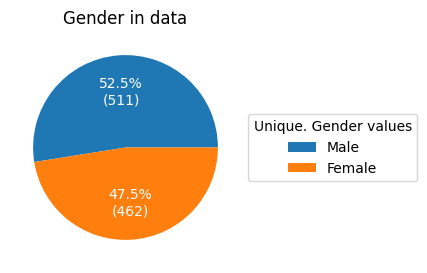

<Figure size 640x480 with 0 Axes>

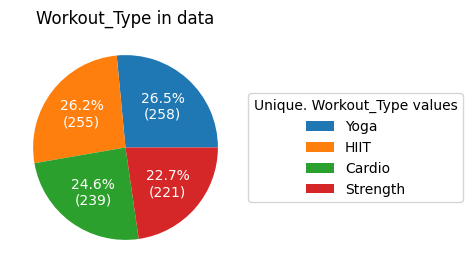

<Figure size 640x480 with 0 Axes>

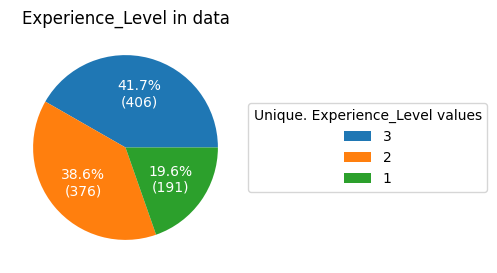

In [7]:
def plot_categorical_data(df, col):
    plt.figure()
    fig, ax = plt.subplots(figsize=(6,3))
    gender_counts = df[col].value_counts().values
    genders = df[col].unique()

    def func(pct, allvals):
        absolute = int(np.round(pct/100.*np.sum(allvals)))
        return f"{pct:.1f}%\n({absolute:d})"

    wedges, texts, autotexts = ax.pie(gender_counts, autopct=lambda pct: func(pct, gender_counts),
                                    textprops=dict(color="w"))
    ax.legend(wedges, genders,
            title=f"Unique. {col} values",
            loc="center left",
            bbox_to_anchor=(1, 0, 0.5, 1))

    ax.set_title(f"{col} in data")

    plt.show()

cat_or_ord = ['Gender', 'Workout_Type', 'Experience_Level']
for catcol in cat_or_ord:
    plot_categorical_data(df, catcol)

The distribution of workout type is quite good, there isn't substantially more from any classes than the other.

The male/ female distribution is also around 50-50.

Our target variables distribution however is not 1/3 for each respective class, so in order for the normal evalution to be meaningful, we will have to be careful about setting the calculation (macro, micro difference).

For the neural network, I wouldn't think this much of a difference will make the model overfit on one class, that would be the case if we were to have 90% for example from some class. In that case weighting and focal loss methods would be helpful, also AUPRC instead of AUROC

Since our prediction target is the experience level, we should analyize it more, like how different ages, genders, workout type influences, how experienced a person is. 

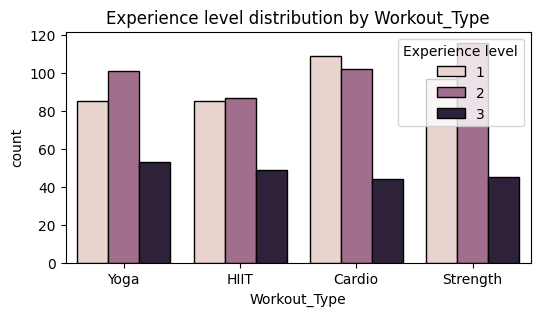

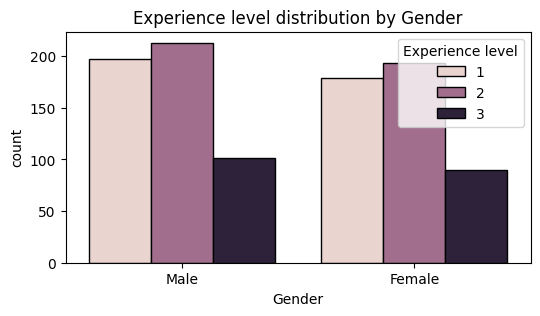

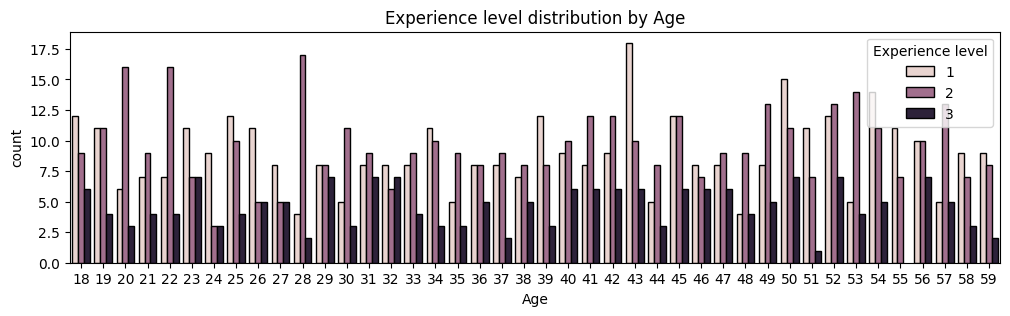

In [8]:
def compare_to_workout_type(df, col, fig=(6,3)):
    plt.figure(figsize=fig)
    sns.countplot(
        data=df,
        x=col,
        hue='Experience_Level',
        edgecolor='black'
    )
    plt.title(f'Experience level distribution by {col}')
    plt.xlabel(f'{col}')
    plt.ylabel('count')
    plt.legend(title='Experience level')

compare_to_workout_type(df, 'Workout_Type')
compare_to_workout_type(df, 'Gender')
compare_to_workout_type(df, 'Age', (12,3))

There are noticeably less highly experienced people in both genders, but there doesn't seem to be a connection between what kind of workouts people choose. The distributions among workout types looks similar.

We also can't see any meaningful relative differences between genders on their experience level.

The age graph tells us absolutely nothing on how experience level are distributed among different age groups, let's create an Age group column just to see it.

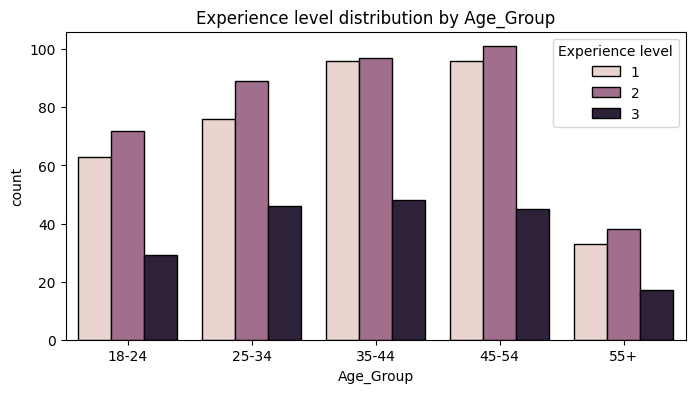

In [9]:
df_age_group = df.copy()
df_age_group['Age_Group'] = pd.cut(
    df['Age'],
    bins=[18, 25, 35, 45, 55, 65],
    labels=['18-24', '25-34', '35-44', '45-54', '55+']
)
compare_to_workout_type(df_age_group, 'Age_Group', fig=(8,4))

This is somewhat expected, older people tend to exercise less, while young adults and middle aged people do more. There isn't once again a clear jump visible on this graph, from which we could tell, that some age group is definietly more experienced than the others.

We can also take a look at the correlation matrix before preprocessing.

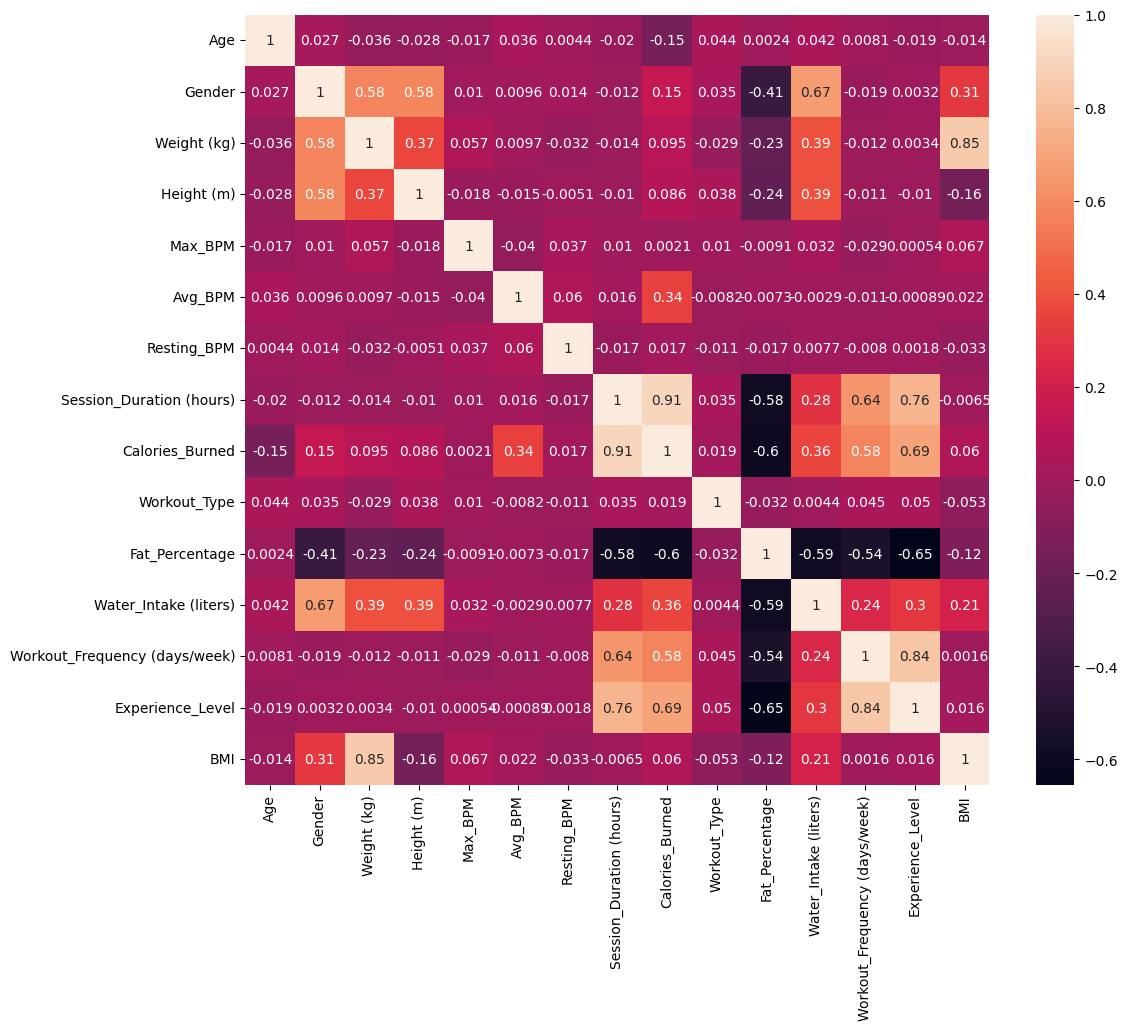

<Figure size 800x600 with 0 Axes>

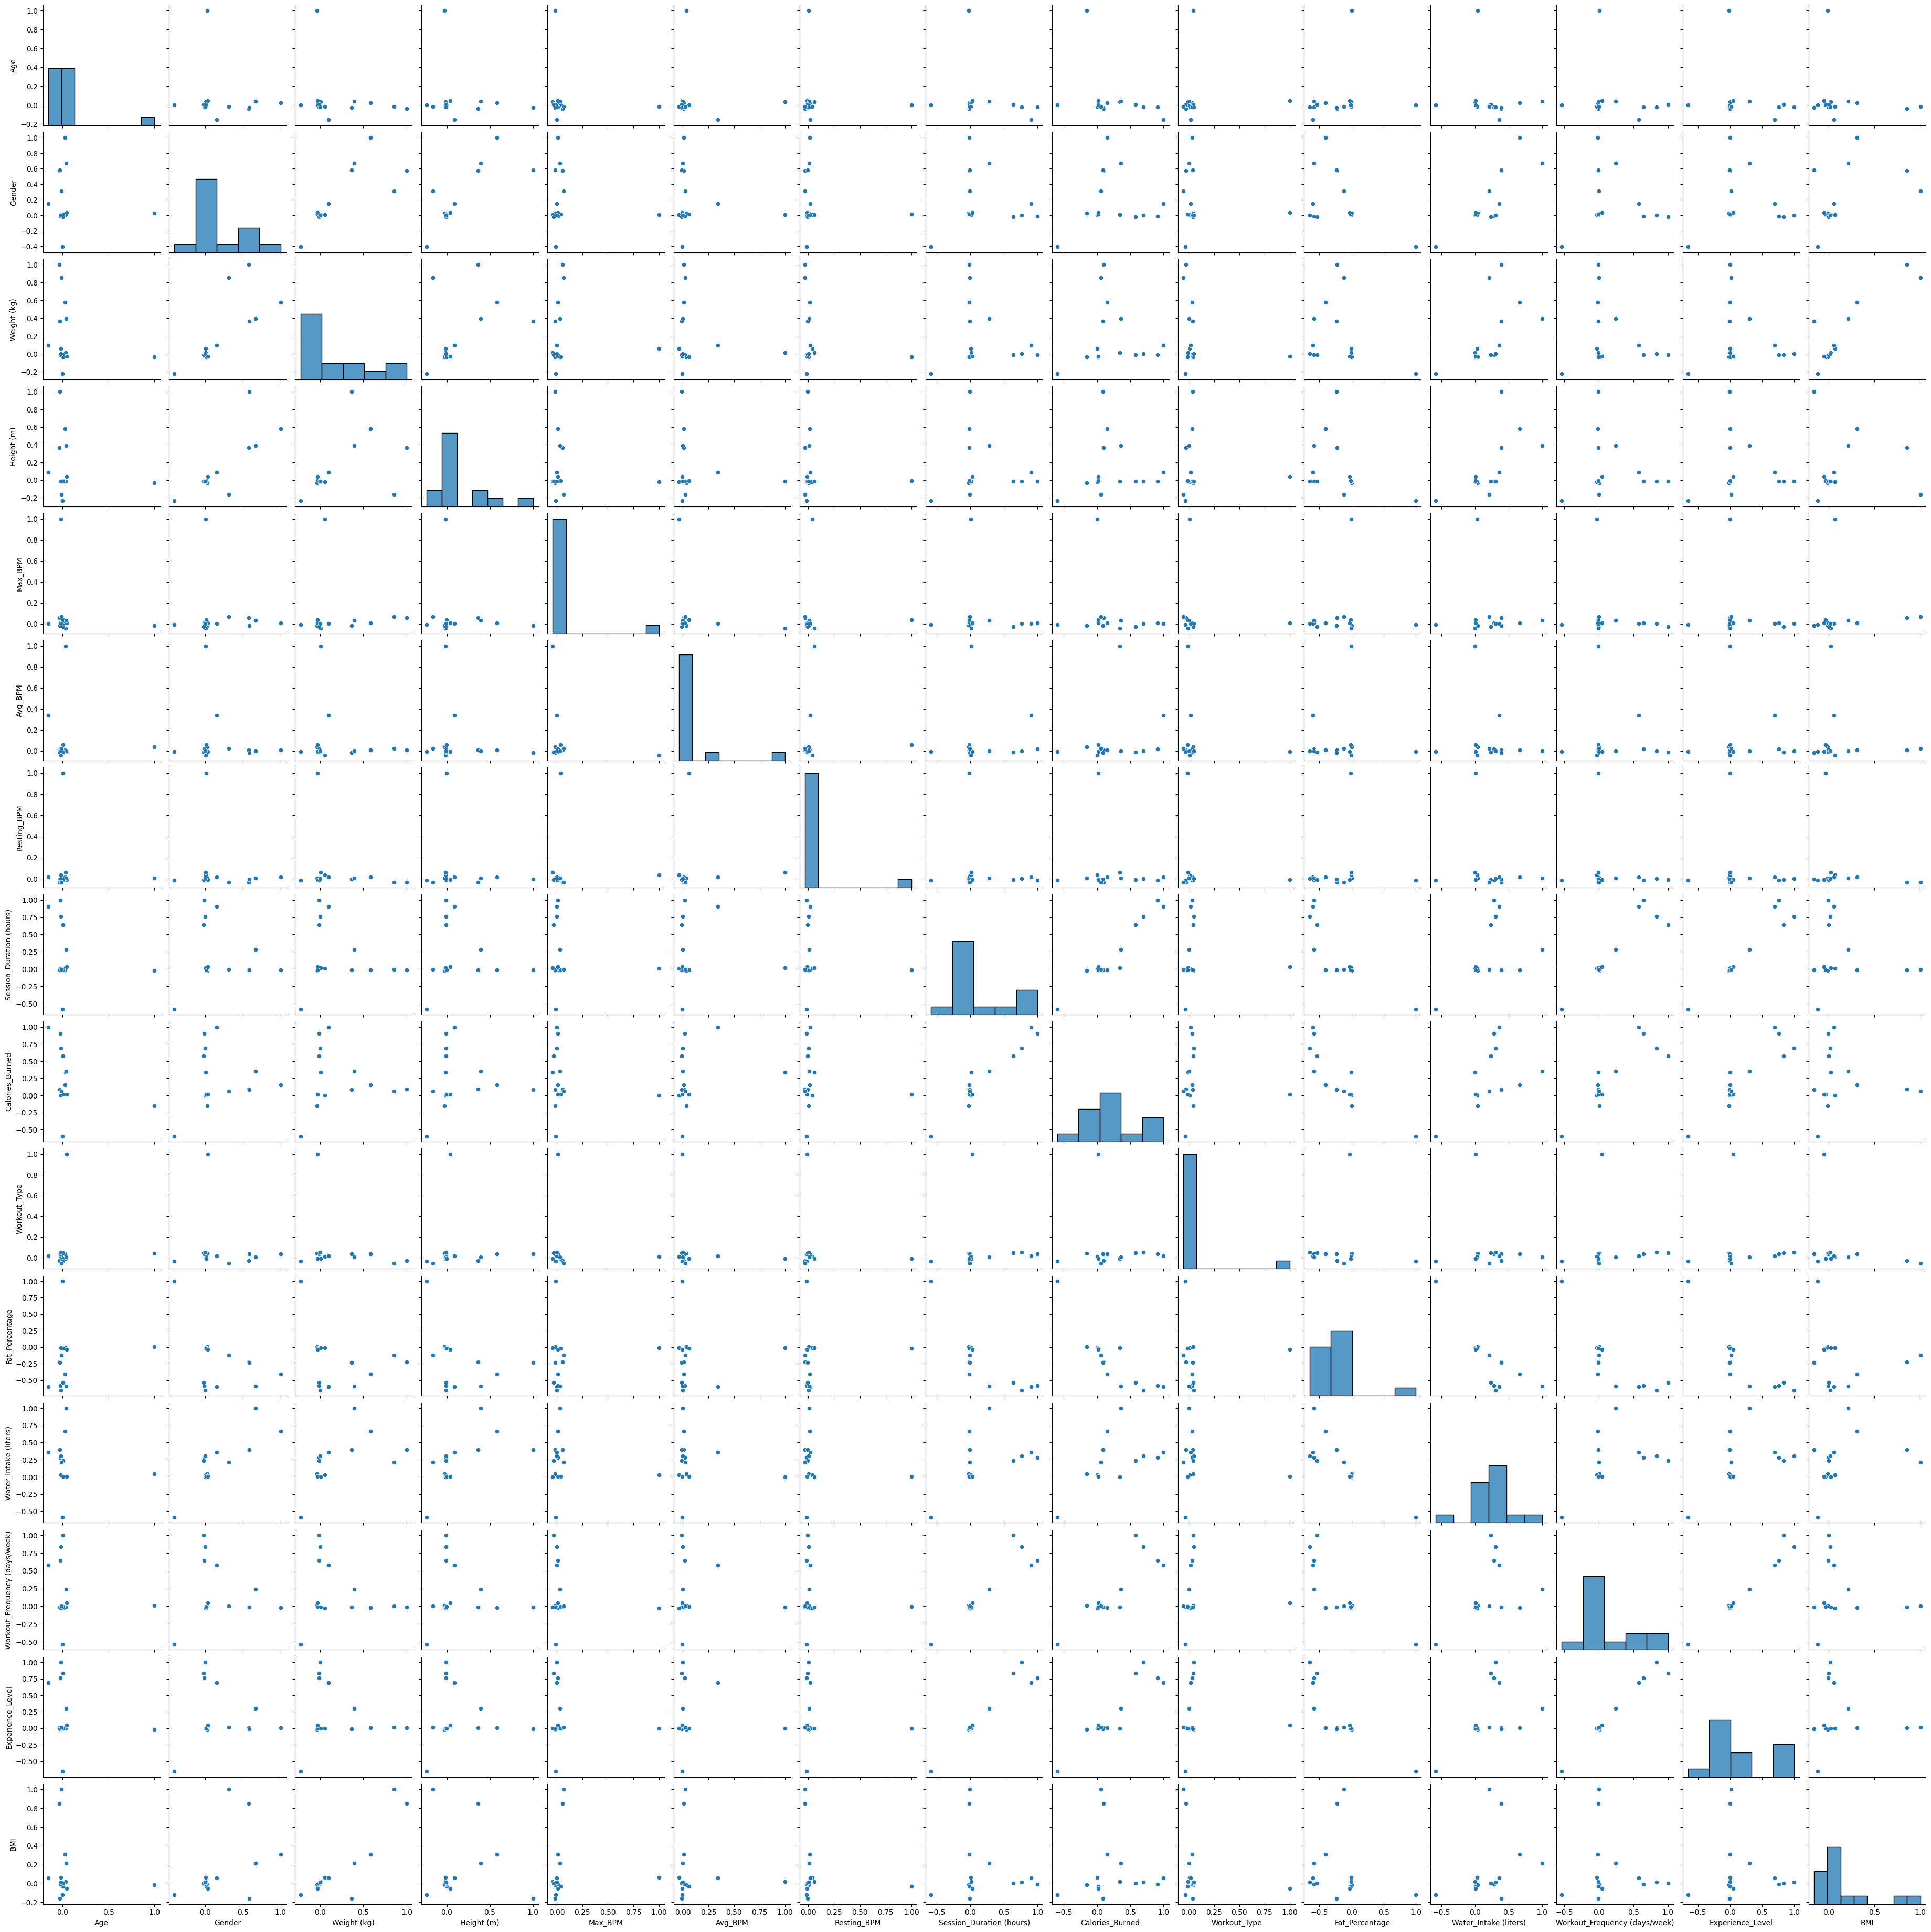

In [ ]:
# we have to encode gender and workout type 
df_encoded = df.copy()
df_encoded['Gender'] = df_encoded['Gender'].map({'Male': 1, 'Female': 0})
df_encoded['Workout_Type'] = df_encoded['Workout_Type'].astype('category').cat.codes

corr_matrix = df_encoded.corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True)
plt.figure(figsize=(8,6))
sns.pairplot(corr_matrix)

From the pairwise plots, we can see that experience level and workout frequency are following the same linear trend, and the same thing is visible when comparing session duration and experience level. Both of their correlation correlation coefficient is above 0.8 as well, they are heavily correlated.

Since these data are not calculated from each other, this could be a meaningful connection for our models to make


NOTE:

At first we wanted to predict `Workout_Type`, but after reaching the modeling stage, none of the models were able to outperform random guessing. When choosing this dataset, there wasn't a clear Y variable given, as this dataset is mainly for understanding connections between different variables. However some people did BMI, calories burned, experience level prediction and other classification/regression tasks, we opted to pivot, and use experience level as our target variable. This way we can create meaningful models, which are interpretable (well not the nn based), and maybe useful.

